In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Import

In [25]:
data = pd.read_excel('statistic_id245347_total-medicaid-enrollment-1966-2022.xlsx',sheet_name = 'Data')
data = data.iloc[4:,1:]
data.columns = ['date','enrollment']
data['date'] = pd.to_datetime(data['date'].astype(str) + '-01-01')
data['enrollment'] = data['enrollment']*1000000
data

,date,enrollment
4,1966-01-01,4000000.0
5,1970-01-01,14000000.0
6,1975-01-01,20200000.0
7,1980-01-01,19600000.0
8,1985-01-01,19800000.0
9,1990-01-01,22800000.0
10,1995-01-01,32300000.0
11,2000-01-01,34100000.0
12,2001-01-01,36800000.0
13,2002-01-01,40400000.0


In [26]:
train = data[data['date']<'2018-01-01']
valid = data[data['date']>'2017-01-01']
train.set_index('date',inplace = True)
valid.set_index('date',inplace=True)
valid

,enrollment
date,
2018-01-01,73400000.0
2019-01-01,72900000.0
2020-01-01,76200000.0
2021-01-01,84700000.0
2022-01-01,90800000.0


# EDA

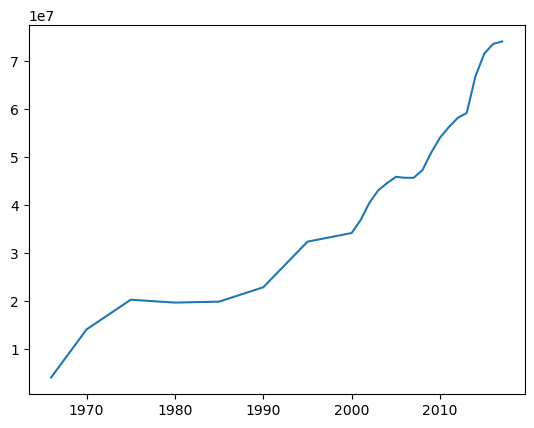

In [5]:
plt.plot(train)

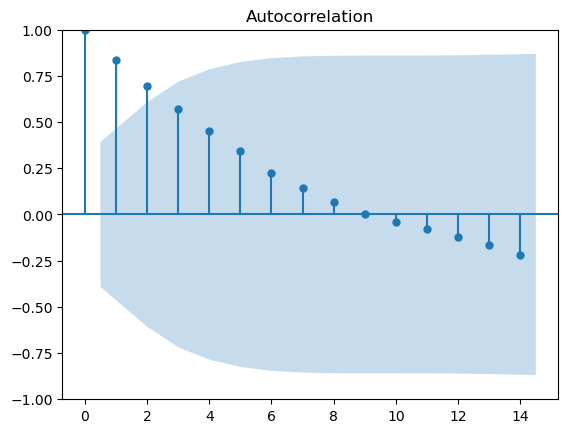

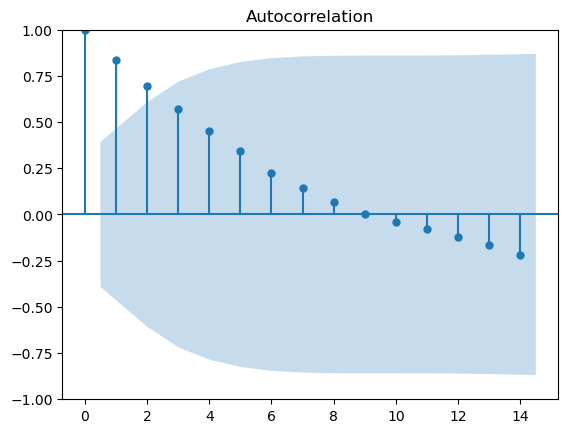

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train)

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['enrollment'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -1.639355
p-value: 0.462598


# Model Training

#### Holt-winter

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw_ad = ExponentialSmoothing(train['enrollment'],trend = 'add').fit()
pre_hw_ad = model_hw_ad.forecast(5)

/Users/feierx/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/feierx/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/feierx/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/feierx/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [12]:
model_hw_mul = ExponentialSmoothing(train['enrollment'],trend = 'mul').fit()
pre_hw_mul = model_hw_mul.forecast(5)

/Users/feierx/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/feierx/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/feierx/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#### ARIMA

In [13]:
from pmdarima import auto_arima

# Run the auto_arima function to find the best ARIMA parameters
model_arima = auto_arima(train['enrollment'], seasonal=False, stepwise=True, trace=True,
                   error_action='ignore', suppress_warnings=True)

# model.summary() will give you a summary of the best model found by auto_arima
print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=790.788, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=784.794, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=786.523, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=786.368, Time=0.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=800.388, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=787.853, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.049 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -390.397
Date:                Tue, 30 Apr 2024   AIC                            784.794
Time:                        21:44:55   BIC                            787.150
Sample:                             0   HQIC                           785.419
                

In [15]:
pre_arima = model_arima.predict(n_periods=5)

/Users/feierx/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/feierx/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### Prophet

In [18]:
train_p = train.resample('MS').interpolate(method='spline',order = 2)
train_p = train_p.reset_index()
train_p.columns = ['ds','y']
train_p = train_p[train_p['ds']>'2004-12-31']

In [19]:
from prophet import Prophet
m = Prophet()
m.fit(train_p)

future = m.make_future_dataframe(periods=5,freq='YS')
forecast = m.predict(future)
result = forecast[['ds','yhat']]

pre_pro = result[result['ds']>"2017-01-01"]['yhat']

21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing


# Evaluation

In [21]:
from sklearn.metrics import mean_squared_error
print('ARIMA',np.sqrt(mean_squared_error(valid['enrollment'],pre_arima)))
print('Holt-Winter Additive Trend',np.sqrt(mean_squared_error(valid['enrollment'],pre_hw_ad)))
print('Holt-Winter Multiplicative Trend',np.sqrt(mean_squared_error(valid['enrollment'],pre_hw_mul)))
print('Prophet',np.sqrt(mean_squared_error(valid['enrollment'],pre_pro)))

ARIMA 4673084.872139846
Holt-Winter Additive Trend 4743465.841460292
Holt-Winter Multiplicative Trend 5350256.866874312
Prophet 4904603.580743498


# Refit the optimal model

In [28]:
from pmdarima import auto_arima

# Run the auto_arima function to find the best ARIMA parameters
model = auto_arima(data['enrollment'], seasonal=False, stepwise=True, trace=True,
                   error_action='ignore', suppress_warnings=True)

# model.summary() will give you a summary of the best model found by auto_arima
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=948.938, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=950.577, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=949.791, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=948.774, Time=0.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=969.000, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=950.123, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=954.768, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=954.875, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=956.580, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.194 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   30
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -471.387
Date:                Tue, 30 Apr 2024   AIC               

In [29]:
arima_predict = model.predict(n_periods=10)
arima_predict

34    9.365023e+07
35    9.589223e+07
36    9.813422e+07
37    1.003762e+08
38    1.026182e+08
39    1.048602e+08
40    1.071022e+08
41    1.093442e+08
42    1.115862e+08
43    1.138282e+08
dtype: float64

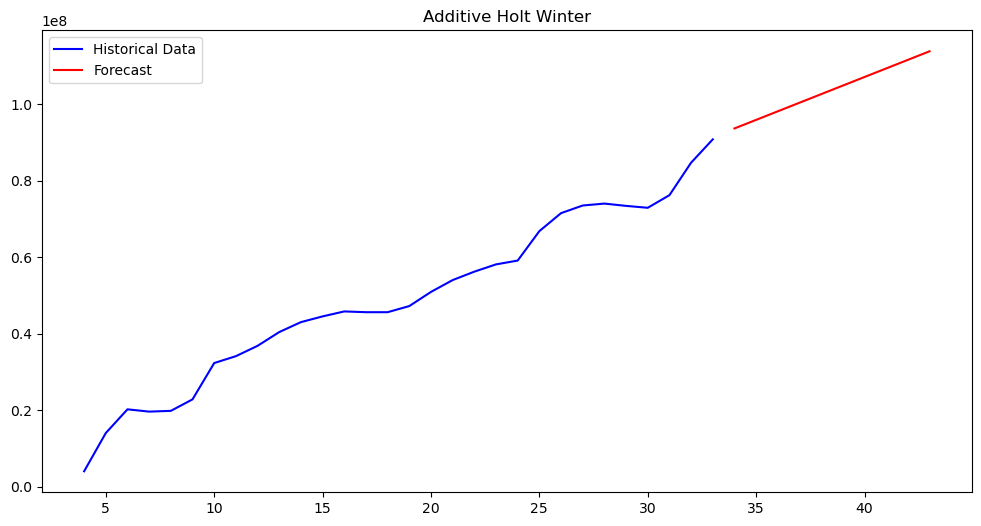

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['enrollment'], label='Historical Data', color='blue')
plt.plot(arima_predict.index, arima_predict, label='Forecast', color='red')
plt.title('Additive Holt Winter')
plt.legend()

In [32]:
model = ExponentialSmoothing(data['enrollment'],trend = 'add').fit()
prediction = model.forecast(10)
prediction

/Users/feierx/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


34    9.403152e+07
35    9.727779e+07
36    1.005241e+08
37    1.037703e+08
38    1.070166e+08
39    1.102629e+08
40    1.135091e+08
41    1.167554e+08
42    1.200017e+08
43    1.232480e+08
dtype: float64

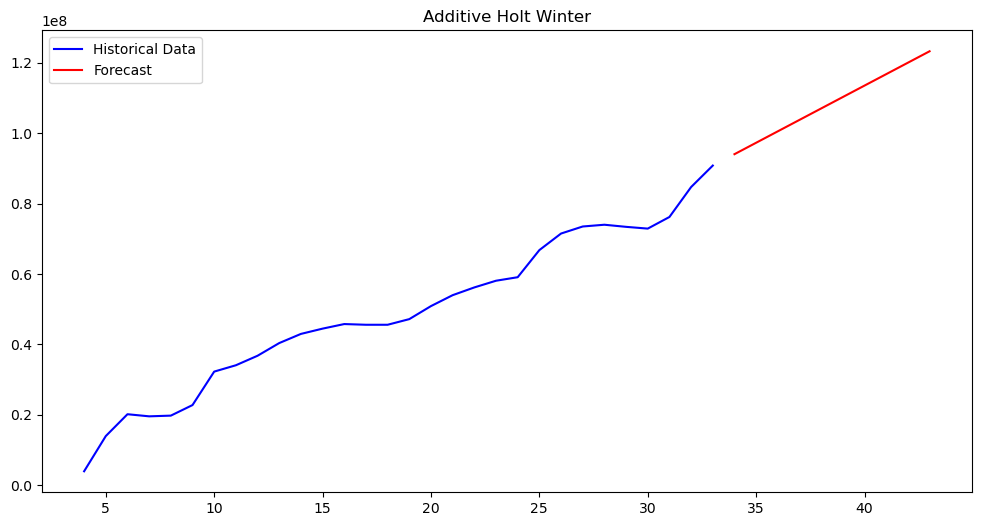

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['enrollment'], label='Historical Data', color='blue')
plt.plot(prediction.index, prediction, label='Forecast', color='red')
plt.title('Additive Holt Winter')
plt.legend()

In [34]:
model = ExponentialSmoothing(data['enrollment'],trend = 'mul').fit()
prediction = model.forecast(10)
prediction

/Users/feierx/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


34    9.727261e+07
35    1.043002e+08
36    1.118355e+08
37    1.199152e+08
38    1.285786e+08
39    1.378679e+08
40    1.478284e+08
41    1.585084e+08
42    1.699601e+08
43    1.822391e+08
dtype: float64

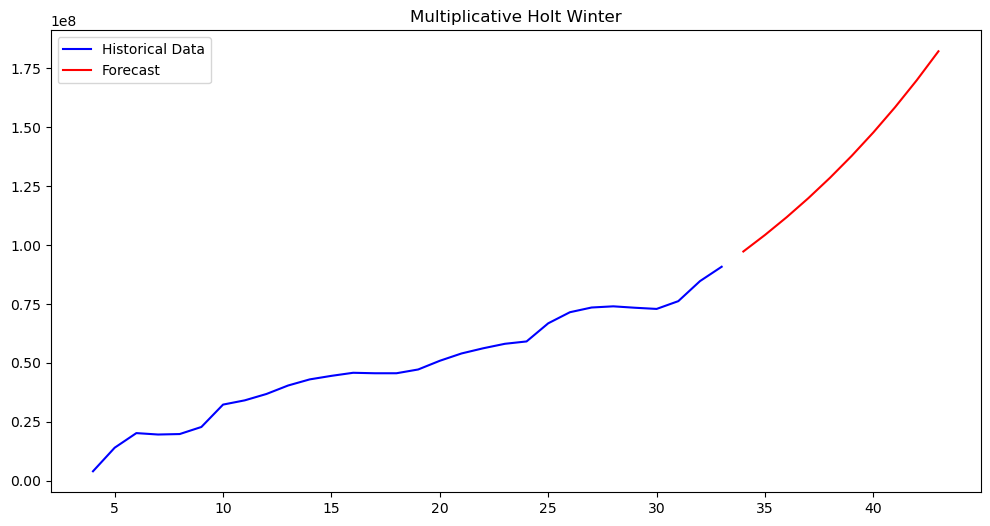

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['enrollment'], label='Historical Data', color='blue')
plt.plot(prediction.index, prediction, label='Forecast', color='red')
plt.title('Multiplicative Holt Winter')
plt.legend()

In [ ]:
data.tail(10)

,date,spending
43,2013-01-01,4.560386e+11
44,2014-01-01,4.946800e+11
45,2015-01-01,5.490622e+11
46,2016-01-01,5.772512e+11
47,2017-01-01,6.000432e+11
48,2018-01-01,6.160970e+11
49,2019-01-01,6.269300e+11
50,2020-01-01,6.827060e+11
51,2021-01-01,7.482187e+11
52,2022-01-01,8.242363e+11
